## Normalisation and Augmentation in Medical Imaging
An essential preprocessing step in medical imaging (especially with MRI images) is normalisation. Below we demonstrate some standard options for normalisation and data augmentation. 

### 1. Data normalisation
Below are some basic examples for data normalisation implemented in DLTK.

In [1]:
import SimpleITK as sitk
import os
import pandas as pd

from matplotlib import pyplot as plt

from dltk.io.augmentation import *
from dltk.io.preprocessing import *

%matplotlib inline

Fetch a single MRI image using part of the reader function defined in the data io notebook

In [2]:
# Read subject information and data paths
data_path = '../../data/IXI_HH/1mm'
all_filenames = pd.read_csv(
    '../../data/IXI_HH/demographic_HH.csv',
    dtype=object,
    keep_default_na=False,
    na_values=[]).as_matrix()

# Keep the first subject
first_subject = all_filenames[0]

# Here, we parse the `subject_id` to construct a file path to read
# an image from.
subject_id = first_subject[0]
data_path = '../../data/IXI_HH/1mm'
t1_fn = os.path.join(data_path, '{}/T1_1mm.nii.gz'.format(subject_id))

# Read the .nii image containing a brain volume with SimpleITK and get 
# the numpy array:
sitk_t1 = sitk.ReadImage(t1_fn)
t1 = sitk.GetArrayFromImage(sitk_t1)

### Intensity normalisation methods

In [3]:
# Normalise the image to zero mean/unit std dev using volume statistics:
t1_white = whitening(t1)

# Normalise the image to fit [0, 1] range:
t1_norm_zo = normalise_zero_one(t1)

# Normalise the image to fit [-1, 1] range:
t1_norm_oo = normalise_one_one(t1)

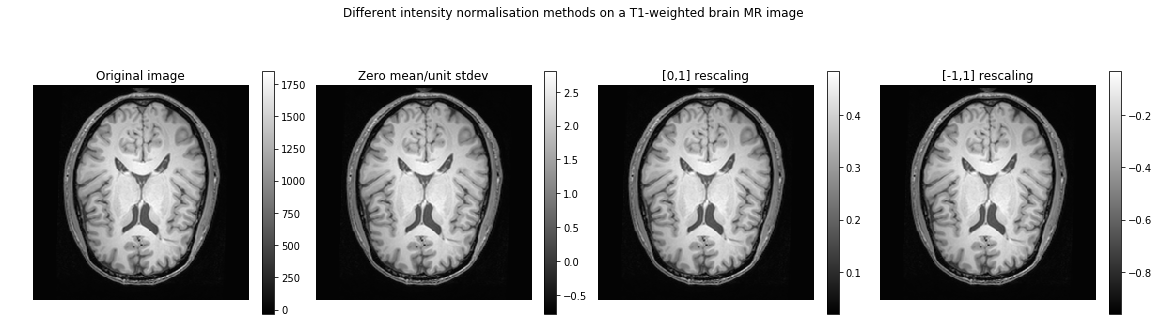

In [4]:
# Visualise using matplotlib.
center_slices = [s//2 for s in t1.shape]

f, axarr = plt.subplots(1, 4, figsize=(20,5));
f.suptitle('Different intensity normalisation methods on a T1-weighted brain MR image')

img = axarr[0].imshow(np.squeeze(t1[center_slices[0], :, :]), cmap='gray');
axarr[0].axis('off')
axarr[0].set_title('Original image')
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(t1_white[center_slices[0], :, :]), cmap='gray');
axarr[1].axis('off')
axarr[1].set_title('Zero mean/unit stdev')
f.colorbar(img, ax=axarr[1])

img = axarr[2].imshow(np.squeeze(t1_norm_zo[center_slices[0], :, :]), cmap='gray');
axarr[2].axis('off')
axarr[2].set_title('[0,1] rescaling')
f.colorbar(img, ax=axarr[2])

img = axarr[3].imshow(np.squeeze(t1_norm_oo[center_slices[0], :, :]), cmap='gray');
axarr[3].axis('off')
axarr[3].set_title('[-1,1] rescaling')
f.colorbar(img, ax=axarr[3])
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show(); 

### Automatic image resizing

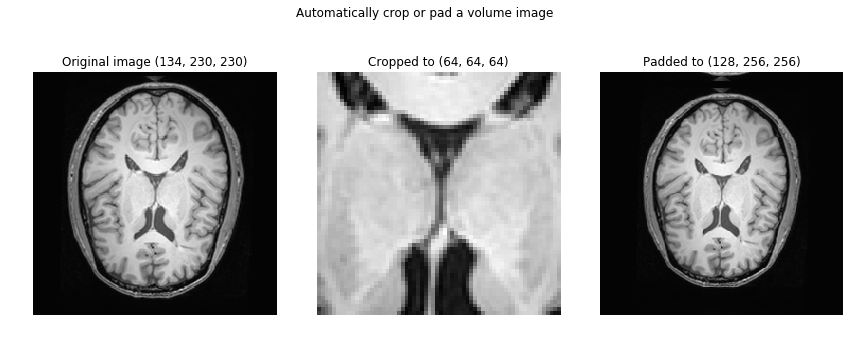

In [5]:
# Crop to [64, 64, 64]
t1_cropped = resize_image_with_crop_or_pad(t1, [64, 64, 64], mode='symmetric')

# Resizing image to [128, 256, 256] required padding
t1_padded = resize_image_with_crop_or_pad(t1, [128, 256, 256], mode='symmetric')

# Visualise using matplotlib.
f, axarr = plt.subplots(1, 3, figsize=(15,5));
f.suptitle('Automatically crop or pad a volume image')

axarr[0].imshow(np.squeeze(t1[t1.shape[0]//2, :, :]), cmap='gray');
axarr[0].axis('off')
axarr[0].set_title('Original image {}'.format(t1.shape))

axarr[1].imshow(np.squeeze(t1_cropped[t1_cropped.shape[0]//2, :, :]), cmap='gray');
axarr[1].axis('off')
axarr[1].set_title('Cropped to {}'.format(t1_cropped.shape))

axarr[2].imshow(np.squeeze(t1_padded[t1_padded.shape[0]//2, :, :]), cmap='gray');
axarr[2].axis('off')
axarr[2].set_title('Padded to {}'.format(t1_padded.shape))
    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show(); 

### 2. Data augmentation

Below we apply different augmentation techniques, which are commonly used for enriching the training dataset and training more robust models. These are applied to the whitened normalised image computed above.

In [6]:
# For demo purposes, extract a 2D slice from the image volume. This is just to better
# demonstrate the Gaussian offset augmentation. To demonstrate, that this works on 
# volumes, we ensure that the slice is a 3D volume: 
center_slices = [s//2 for s in t1.shape]
t1_slice = t1[center_slices[0]:center_slices[0]+1,:,:].copy()
print(t1_slice.shape)

# Add a feature dimension and normalise
t1_norm = np.expand_dims(normalise_one_one(t1_slice), axis=-1)

# Randomly flip the image along axis 1
t1_flipped = flip(t1_norm.copy(), axis=1)

# Add a Gaussian offset (independently for each channel)
t1_offset = add_gaussian_offset(t1_norm.copy(), sigma=0.5)

# Add Gaussian noise
t1_noise = add_gaussian_noise(t1_norm.copy(), sigma=0.25)

# Elastic transforms according to:
# [1] Simard, Steinkraus and Platt, "Best Practices for Convolutional
#     Neural Networks applied to Visual Document Analysis", in Proc. of the
#     International Conference on Document Analysis and Recognition, 2003.
t1_trans_low_s = elastic_transform(t1_norm.copy(), alpha=[1, 1e5, 1e5], sigma=[1, 10, 10])
t1_trans_high_s = elastic_transform(t1_norm.copy(), alpha=[10, 2e6, 2e6], sigma=[1, 25, 25])

(1, 230, 230)


Plot results of the different augmentations techniques

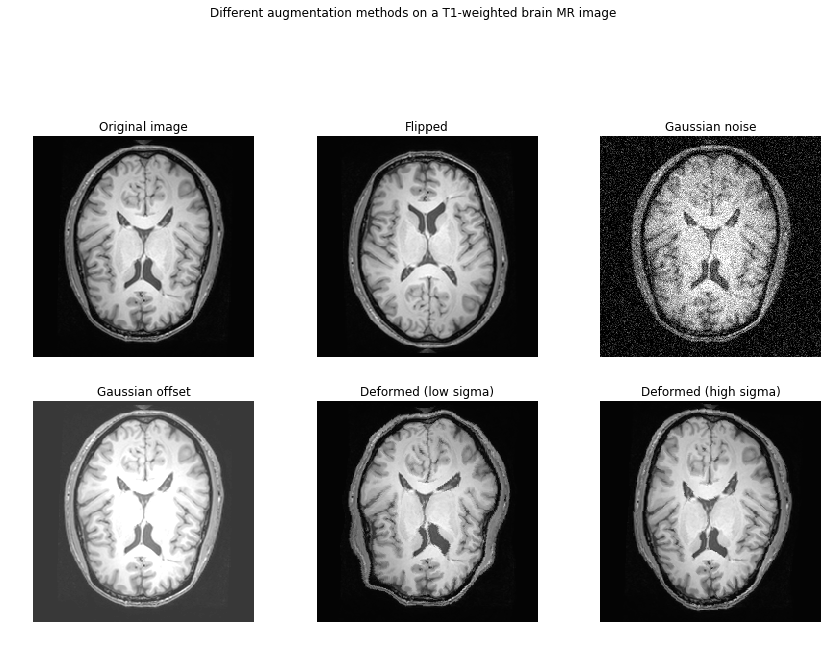

In [7]:
# Visualise using matplotlib
f, axarr = plt.subplots(2, 3, figsize=(15,10));
f.suptitle('Different augmentation methods on a T1-weighted brain MR image')

axarr[0,0].imshow(np.squeeze(t1_norm), cmap='gray', vmin=-1, vmax=1);
axarr[0,0].axis('off')
axarr[0,0].set_title('Original image')

axarr[0,1].imshow(np.squeeze(t1_flipped), cmap='gray', vmin=-1, vmax=1);
axarr[0,1].axis('off')
axarr[0,1].set_title('Flipped')

axarr[0,2].imshow(np.squeeze(t1_noise), cmap='gray', vmin=-1, vmax=1);
axarr[0,2].axis('off')
axarr[0,2].set_title('Gaussian noise')

axarr[1,0].imshow(np.squeeze(t1_offset), cmap='gray', vmin=-1, vmax=1);
axarr[1,0].axis('off')
axarr[1,0].set_title('Gaussian offset')

axarr[1,1].imshow(np.squeeze(t1_trans_low_s), cmap='gray', vmin=-1, vmax=1);
axarr[1,1].axis('off')
axarr[1,1].set_title('Deformed (low sigma)')

axarr[1,2].imshow(np.squeeze(t1_trans_high_s), cmap='gray', vmin=-1, vmax=1);
axarr[1,2].axis('off')
axarr[1,2].set_title('Deformed (high sigma)')
    
f.subplots_adjust(wspace=0.05, top=0.8)
plt.show(); 

Plot difference between elastic transformed images and original whitened image

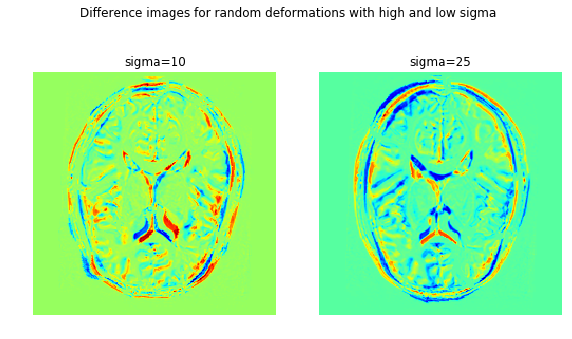

In [8]:
f, axarr = plt.subplots(1, 2, figsize=(10,5));
f.suptitle('Difference images for random deformations with high and low sigma')

axarr[0].imshow(np.squeeze(t1_norm-t1_trans_low_s), cmap='jet');
axarr[0].axis('off')
axarr[0].set_title('sigma=10')

axarr[1].imshow(np.squeeze(t1_norm-t1_trans_high_s), cmap='jet');
axarr[1].axis('off')
axarr[1].set_title('sigma=25')

f.subplots_adjust(wspace=0.05, top=0.8)
plt.show();